# Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Data:
The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

# Skin diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


# Solution:
Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

### Importing all the important libraries

In [100]:
import pathlib
import os

# Numpy and Pandas libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

# Deep learning liberaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Import Tensorflow liberaries
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping



In [101]:
# Check the number of GPU's avilable
print("# of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

# of GPUs available:  1


In [102]:
# Comment out as needed. Kept for clean run as and when needed
!rm -r '/content/Skin cancer ISIC The International Skin Imaging Collaboration'

In [103]:
# Connect to data source using google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# Unzip the input file
!unzip '/content/drive/MyDrive/Melanoma Detection Assignment/CNN_assignment'
print("Unzip done")

Archive:  /content/drive/MyDrive/Melanoma Detection Assignment/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/I

### Observation:
- Data has been downloaded and stored in a folder 'images' divided into 'train' and 'test' folder.

### Defining the path for train and test images

In [105]:
trained_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
tested_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
data_dir_train = pathlib.Path(trained_path)
data_dir_test = pathlib.Path(tested_path)

In [106]:
# Initial counts of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('image_count_train:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('image_count_test :', image_count_test)

image_count_train: 2239
image_count_test : 118


### Observation:
- This assignment uses a dataset of about 2357 (2239+118) images of skin cancer types.
- The dataset contains 9 sub-directories in each train and test subdirectories.
- The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

- Define some parameters for the loader:
- Use 80% of the images for training, and 20% for validation.

In [107]:
batch_size = 32  # samples/images that will be processed in one iteration during training or evaluation of a
                 # machine learning model. A batch size of 32 means that 32 images will be processed together
img_height = 180 # images are expected to have a square shape with both dimensions set to 180 pixels.
img_width = 180  # images are expected to have a square shape with both dimensions set to 180 pixels.
seed = 123 # Random seed ensures that random processes produce the same results every time the code is run,
           # which can be helpful for debugging or reproducing specific results.

### Train Dataset

In [108]:
# Let's load these images off disk using the helpful image_dataset_from_directory utility.
# seed=123
# Resize your images to the size img_height*img_width, while writting the dataset
# Create the training dataset with 80% for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


### Validation Dataset

In [109]:
# seed=123
# Resize your images to the size img_height*img_width, while writting the dataset
# Create the validation dataset with 20% for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [110]:
# List out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Observation:
- We have 1792 files for training
- We have 447 files for validation
- Total 9 classes of skin cancer

### Visualize the data

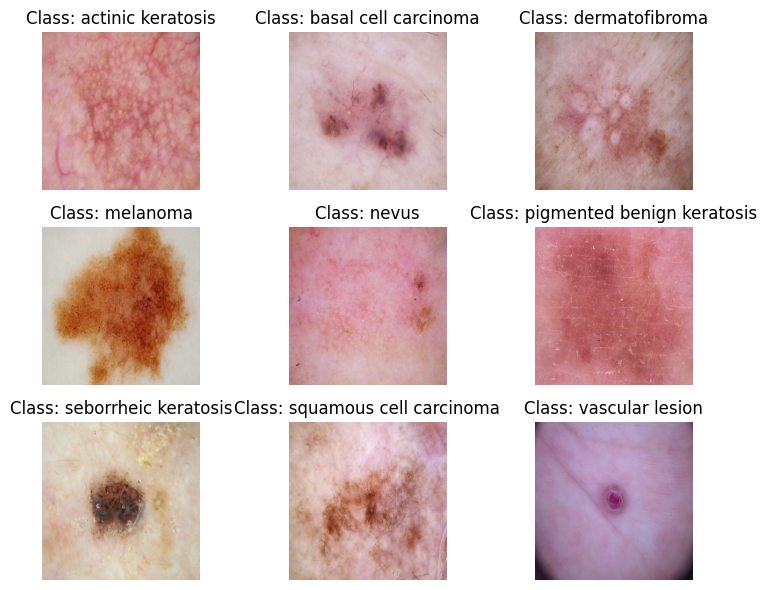

In [111]:
import matplotlib.pyplot as plt

# Assuming train_ds contains your training dataset and class_names contains the list of class names

# Create a dictionary to keep track of the first image from each class
class_images = {}
num_classes = len(class_names)  # Number of classes to visualize

# Iterate through the dataset to find one image from each class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        label = int(label.numpy())  # Convert label tensor to integer
        if label not in class_images:
            class_images[label] = image.numpy()
            if len(class_images) == num_classes:
                break
    if len(class_images) == num_classes:
        break

# Visualize one instance from each class with class names
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.subplot(3, 3, i + 1)
    plt.imshow(class_images[i].astype("uint8"))  # Assuming images are normalized, convert back for display
    plt.title(f"Class: {class_names[i]}")  # Use class names here
    plt.axis("off")
plt.tight_layout()
plt.show()

### Observation:
- Total 9 classes of skin cancer are visually observed

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Cache and Prefetch
- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [112]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
- Create a CNN model, which can accurately detect 9 classes present in the dataset.
- We shall Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1).
- The RGB channel values are in the `[0, 255]` range.
- This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [113]:
# Define the input shape
num_classes = len(class_names) # 9 Classes as per Dataset

# Define the Rescaling layer for normalization pixel values between (0,1)
rescale = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

### BASE MODEL

In [114]:
model=Sequential([
    rescale,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

### Compile the model - Choose loss function as appropriate

In [115]:
# This loss function calculates the cross-entropy loss between the predicted probability distribution
# (from the model) and the true probability distribution (represented by the integers denoting class indices).
# It essentially measures the dissimilarity or "distance" between the predicted class probabilities and the actual
# target class.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

### Train the model

In [116]:
# This sets the number of epochs for training the model.
# An epoch is one complete pass through the entire training dataset.
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 102ms/step - loss: 2.8506 - accuracy: 0.1998 - val_loss: 2.1559 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9720 - accuracy: 0.2684 - val_loss: 2.0127 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.8442 - accuracy: 0.3326 - val_loss: 1.7844 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6467 - accuracy: 0.4291 - val_loss: 1.5416 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5318 - accuracy: 0.4766 - val_loss: 1.4459 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.4487 - accuracy: 0.5123 - val_loss: 1.4570 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.3708 - accuracy: 0.5251 - val_loss: 1.4509 - val_accuracy: 0.5347
Epoch 8/20


### Vizualizing the model

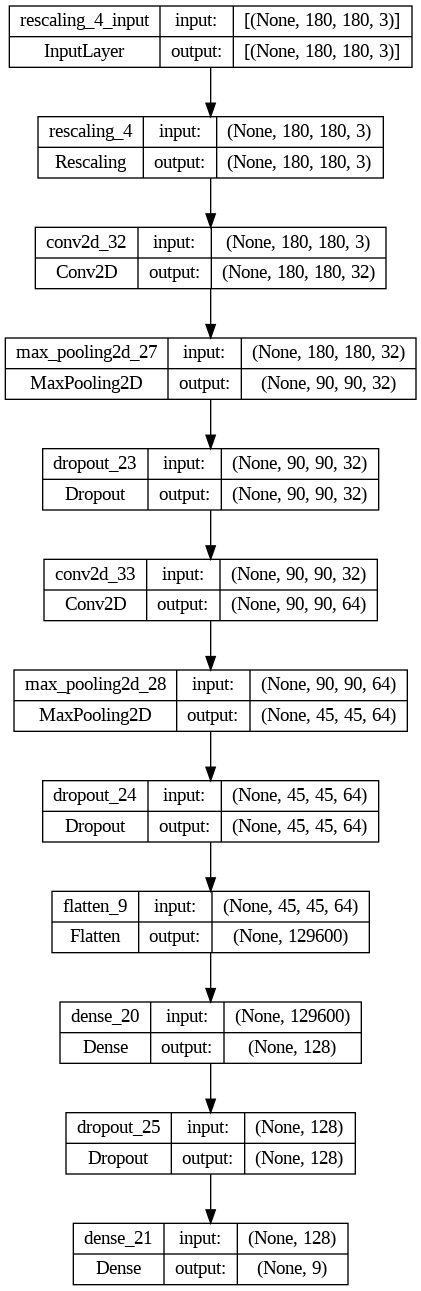

In [117]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Visualizing training results

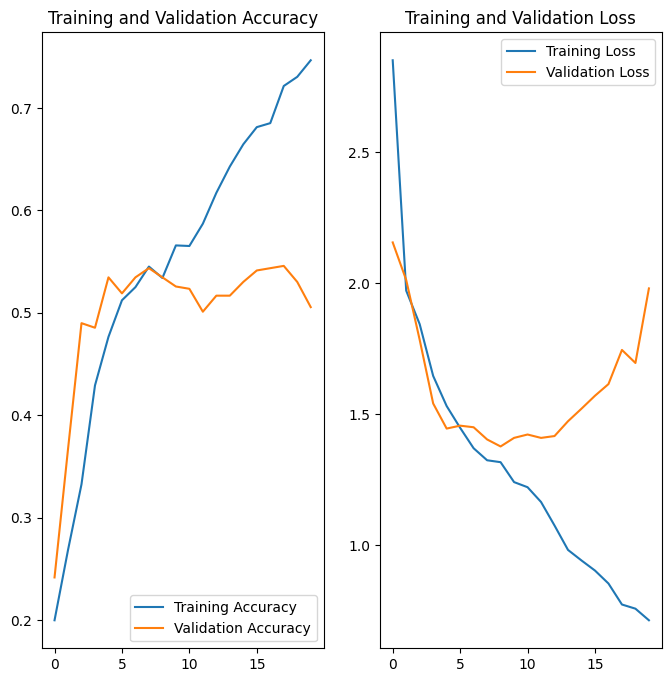

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- Clear evidence of model overfitting is apparent due to a significant disparity between training accuracy and validation accuracy.
- This pattern is also reflected in the Training Loss versus Validation Loss.
- Overfitting can occur, particularly when the training dataset is limited, causing the model to learn from irrelevant details or noise, negatively affecting its performance on new examples.
- The model achieves a Training Dataset accuracy of 74%, but the Validation accuracy falls notably short around 54%. - - This substantial deviation indicates overfitting, further supported by the observation of high validation loss.
- These discrepancies suggest a likelihood of overfitting within the model architecture. To address this, adjustments such as incorporating Dropout layers and eliminating BatchNormalization layers could be beneficial.
- Moreover, enhancing the model by introducing additional layers might aid in feature extraction, potentially leading to improved accuracy.
- Thus we can collect that the BASE model is not good.

### Data Augmentation

In [119]:
# As model is overfitting, we need to do Data Augmentation
# augumentation strategy with flip,rotate,skew,shift, zoom, contrast.

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

### Visualizing the Augmented Data

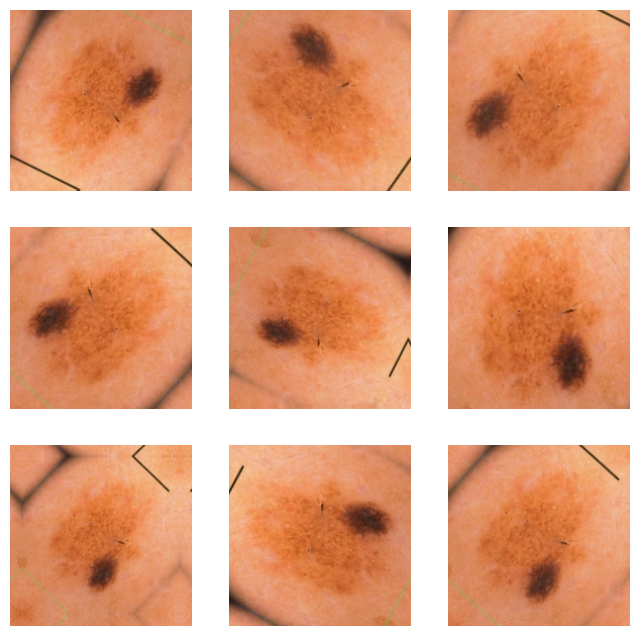

In [120]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
  for i in range(num_classes):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Observations:
- Above visual shows that data augumentaiton was applied sucessfully.
- We can see images flip,rotate,skew,shift, zoom, contrast as per parameters we passed

### MODEL -2 - Using Data Augumented Data

In [121]:
model=Sequential([
    rescale,

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

### Compiling the model

In [122]:
# Appropirate optimiser and loss function

opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 89, 89, 32)        0         
                                                     

### Train the model

In [123]:
# This sets the number of epochs for training the model.
# An epoch is one complete pass through the entire training dataset.

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 116ms/step - loss: 2.0924 - accuracy: 0.1825 - val_loss: 2.0444 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 114ms/step - loss: 2.0098 - accuracy: 0.2054 - val_loss: 1.9039 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 6s 113ms/step - loss: 1.8902 - accuracy: 0.3030 - val_loss: 1.8630 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 6s 114ms/step - loss: 1.7585 - accuracy: 0.3532 - val_loss: 1.6866 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 6s 112ms/step - loss: 1.6909 - accuracy: 0.3979 - val_loss: 1.6474 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6673 - accuracy: 0.3817 - val_loss: 1.9387 - val_accuracy: 0.2752
Epoch 7/20
56/56 [==============================] - 6s 112ms/step - loss: 1.6696 - accuracy: 0.3962 - val_loss: 1.5817 - val_accuracy: 0.4474
Epoch 

### Visualizing the results

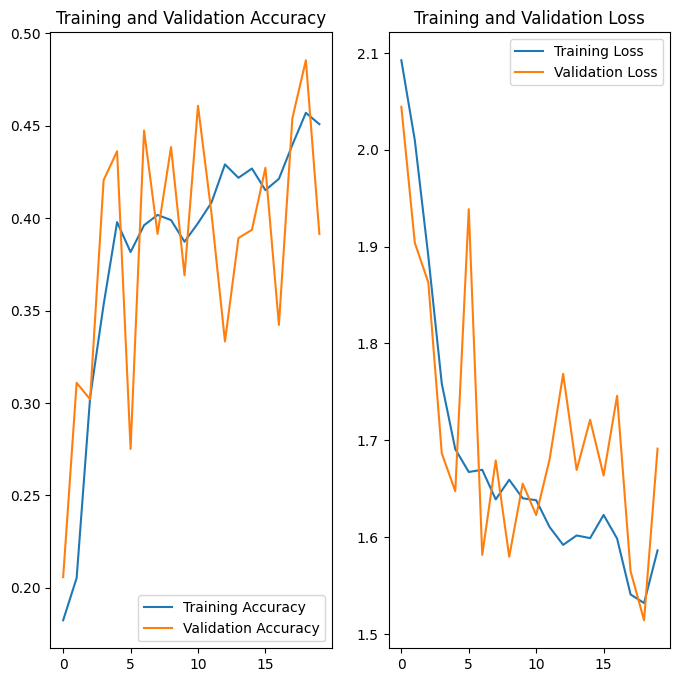

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- The model shows signs of improved generalization when evaluated against validation images.
- However, it seems to face an issue of underfitting due to the scarcity of images for certain classes.
- While the validation and training accuracies are comparable, they both remain suboptimal.
- The model's accuracy on the training dataset has increased to around 45%, with the validation set at 40%.
- This model performs better compared to the previous iterations as there's no evidence of overfitting.
- Both training and validation accuracies stand at around 40%, indicating a balanced model.
- The introduction of data augmentation has notably enhanced the model's performance, leading to improved accuracies.
- Although the similarity between training and validation accuracies indicates a good fit, the overall accuracy remains quite low.
- To further enhance the model, additional training epochs are required, especially considering the existing class imbalance within the dataset.
- The model requires more epochs to train with class imbalance handled.

### Find the distribution of classes in the training dataset.
- Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [125]:
for image_class in class_names:
    n_images_per_class = len(list(data_dir_train.joinpath(image_class).glob('*.jpg')))
    print(f'Image class:  {image_class} is {n_images_per_class} ( {(n_images_per_class/image_count_train)*100:.2f} % of total images)')

Image class:  actinic keratosis is 114 ( 5.09 % of total images)
Image class:  basal cell carcinoma is 376 ( 16.79 % of total images)
Image class:  dermatofibroma is 95 ( 4.24 % of total images)
Image class:  melanoma is 438 ( 19.56 % of total images)
Image class:  nevus is 357 ( 15.94 % of total images)
Image class:  pigmented benign keratosis is 462 ( 20.63 % of total images)
Image class:  seborrheic keratosis is 77 ( 3.44 % of total images)
Image class:  squamous cell carcinoma is 181 ( 8.08 % of total images)
Image class:  vascular lesion is 139 ( 6.21 % of total images)


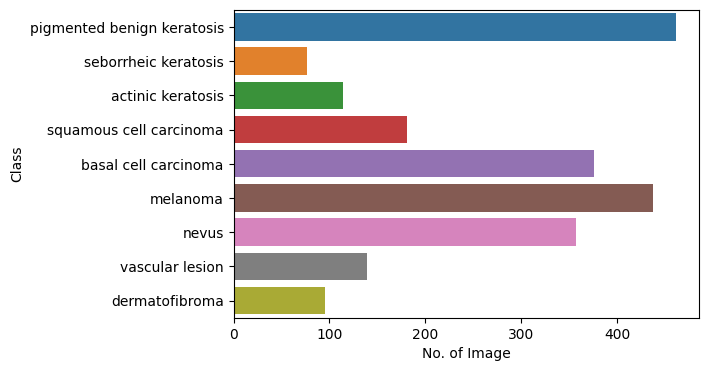

In [126]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]


    #name of the classes
    sub_ptc = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]


    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)

#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()


### Observations
- **Which class has the least number of samples**?
Among all classes, 'seborrheic keratosis' exhibits the fewest samples, totaling 77 images, which accounts for merely 3.44% of the entire dataset.

  
- **Which classes dominate the data in terms proportionate number of samples?**
In terms of the proportionate distribution of samples, 'melanoma' comprises 438 images, representing 19.56% of the total dataset. Additionally, 'pigmented benign keratosis' encompasses 462 images, accounting for 20.63% of the total images, making them the dominant classes within the dataset.

- **Next step** - Add more samples across all classes so that none of the classes have very few samples.

### Rectify the class imbalance
To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [127]:
!pip install Augmentor

In [128]:
path_to_training_dataset=trained_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796416D95CC0>: 100%|██████████| 500/500 [00:17<00:00, 28.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7964C36C9870>: 100%|██████████| 500/500 [00:20<00:00, 24.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7964C1C64190>: 100%|██████████| 500/500 [00:20<00:00, 24.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x796416E13730>: 100%|██████████| 500/500 [01:50<00:00,  4.53 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7964C36CA9E0>: 100%|██████████| 500/500 [01:19<00:00,  6.25 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7964C35F4580>: 100%|██████████| 500/500 [00:17<00:00, 28.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7964542099F0>: 100%|██████████| 500/500 [00:43<00:00, 11.62 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796454359720>: 100%|██████████| 500/500 [00:15<00:00, 32.88 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7964C372AC80>: 100%|██████████| 500/500 [00:15<00:00, 32.22 Samples/s]


### Observations
- Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.
- Lets take a look at total count of augmented images.

### Distribution of augmented data after adding new images to the original training data.

In [129]:
# Image count post augumentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [130]:
# Original image count
image_count_train_orig = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train_orig)

2239


In [131]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [132]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [133]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

In [134]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-134-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [135]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

### Observations
- Now we have added 500 images to all the classes to maintain some class balance.
- We can add more images as we want to improve training process.

### Train the model on the data created using augumentor

In [136]:
batch_size = 32  # samples/images that will be processed in one iteration during training or evaluation of a
                 # machine learning model. A batch size of 32 means that 32 images will be processed together
img_height = 180 # images are expected to have a square shape with both dimensions set to 180 pixels.
img_width = 180  # images are expected to have a square shape with both dimensions set to 180 pixels.
seed = 123 # Random seed ensures that random processes produce the same results every time the code is run,
           # which can be helpful for debugging or reproducing specific results.

### Train Dataset

In [137]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size,
    image_size=(img_height, img_width), label_mode='categorical',
    seed=seed,subset="training",
    validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Validation Dataset

In [138]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width), label_mode='categorical',
    seed=seed,subset="validation",
    validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Observations
- After addressing class imbalance, the dataset consists of 1,347 files for validation
- and 5,392 files for training

### Model post addressing class imbalance

In [139]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model=Sequential([
  rescale,

#First Convulation layer
Conv2D(32,(3,3),activation='relu'),
MaxPooling2D(pool_size=(2,2)),

#Second Convulation Layer
Conv2D(64,(3,3),activation='relu'),
MaxPooling2D(pool_size=(2,2)),

#Third Convulation Layer
Conv2D(128,(3,3),activation='relu'),
MaxPooling2D(pool_size=(2,2)),

#Dropout layer with 50% Fraction of the input units to drop.
Dropout(0.5),

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
Flatten(),

#Dense Layer
Dense(128,activation='relu'),

#Dropout layer with 25% Fraction of the input units to drop.
Dropout(0.25),

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
Dense(len(class_names),activation='softmax')

])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 41, 41, 128)     

In [140]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [141]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint,earlystop]
)

Epoch 1/20
168/169 [============================>.] - ETA: 0s - loss: 1.8882 - accuracy: 0.2742
Epoch 1: val_accuracy improved from -inf to 0.40980, saving model to model.h5
169/169 [==============================] - 45s 244ms/step - loss: 1.8874 - accuracy: 0.2745 - val_loss: 1.5727 - val_accuracy: 0.4098
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/169 [============================>.] - ETA: 0s - loss: 1.5185 - accuracy: 0.4226
Epoch 2: val_accuracy improved from 0.40980 to 0.45731, saving model to model.h5
169/169 [==============================] - 30s 173ms/step - loss: 1.5189 - accuracy: 0.4227 - val_loss: 1.4054 - val_accuracy: 0.4573
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3732 - accuracy: 0.4761
Epoch 3: val_accuracy improved from 0.45731 to 0.47513, saving model to model.h5
169/169 [==============================] - 30s 173ms/step - loss: 1.3732 - accuracy: 0.4761 - val_loss: 1.3778 - val_accuracy: 0.4751
Epoch 4/20
168/169 [============================>.] - ETA: 0s - loss: 1.2948 - accuracy: 0.5147
Epoch 4: val_accuracy improved from 0.47513 to 0.55382, saving model to model.h5
169/169 [==============================] - 30s 176ms/step - loss: 1.2943 - accuracy: 0.5147 - val_loss: 1.1874 - val_accuracy: 0.5538
Epoch 5/20
169/169 [==============================] - ETA: 0s - loss: 1.1381 -

### Visualize the model results

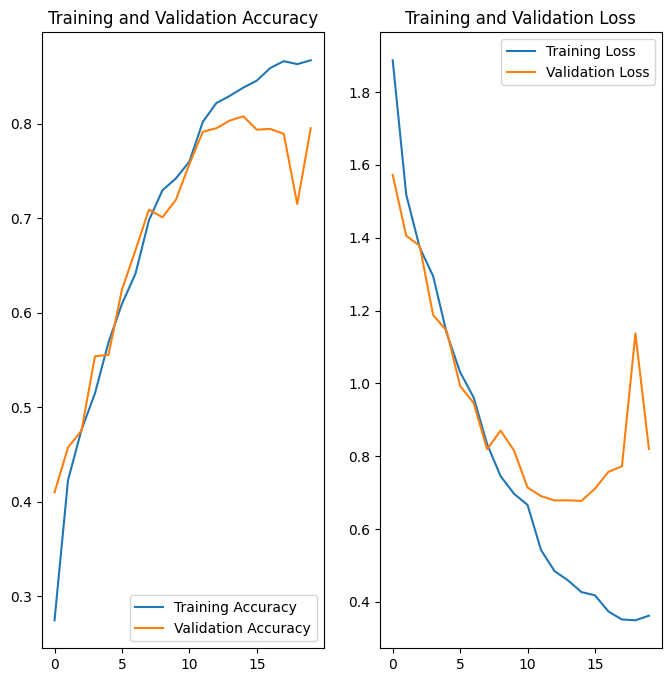

In [142]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations
- The model demonstrates a well-balanced performance with close similarities between training and validation accuracies, along with comparable losses.
- Achieving a validation accuracy of 0.87 (87%) showcases the model's high precision in image classification.
- These outcomes signify notable improvements compared to prior experiments.
- Overfitting has been notably reduced, visible through narrower gaps between training and validation metrics, thanks to addressing class imbalance. Addressing class imbalance has positively influenced the mitigation of underfitting.

**Model Performance Metrics:**
- The training accuracy hovers around ~87%.
- Validation accuracy reaches approximately ~80%.

### Test the Model

1/1 [==============================] - 0s 17ms/step
Actual Class: melanoma
Predictive Class: melanoma


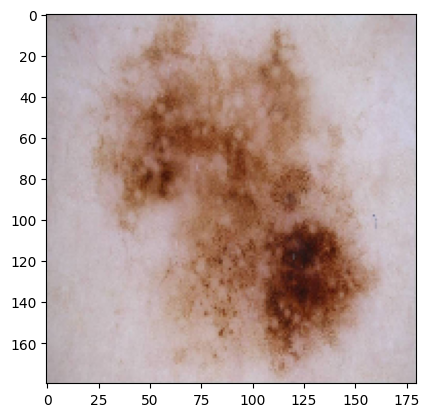

In [144]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class: "+ class_names[3] +'\n'+ "Predictive Class: "+pred_class )

### Observations
**Analysis and Future Steps:**
- The model showcased strong performance on the test dataset, accurately capturing both actual and predicted values.
- Exploring models with increased epochs and additional layers could potentially lead to further enhancements in performance.